In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import sys
from shape_generation import gen_circles, gen_triangles, gen_stars, generate_sum
#, gen_shapes

### Sample call.
The following cell generate a simple image with three types of shapes

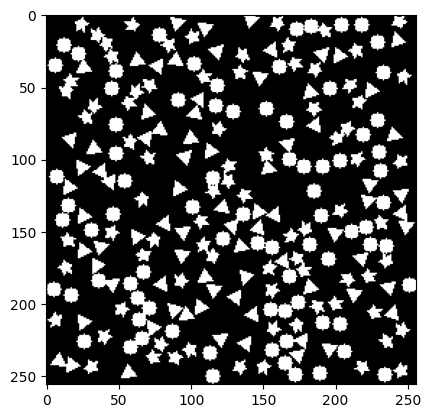

In [7]:
# First, create a black background, with image size 256 x 256
IMG = np.zeros((256, 256), dtype=np.uint8) * 255  # White background


size = 5 

# 5, 10, 15, 20
# 2,4,6,8 equal distribution

NUM_SHAPES = 80
centers = []
IMG, centers, _, fill = gen_triangles(IMG, side_length=size * 2, NUM_SHAPES=NUM_SHAPES)
IMG, centers2, _, fill = gen_stars(IMG, outer_radius=size, inner_radius=size / 2, NUM_SHAPES=NUM_SHAPES, pre_centers = centers)
IMG, centers3, _, fill = gen_circles(IMG, radius=size,NUM_SHAPES= NUM_SHAPES, pre_centers = centers + centers2)
plt.imshow(IMG, cmap = "gray")

### Helper Functions


In [8]:
#################### gen_features() ####################
# This function generates a feature vector that can be used for training
# Outputs: 1 x 15 vector of the total number of shapes, size metrics (mean, min, max) per shape, and fill percentages
def gen_features(numTriangles, numStars, numCircles,
                 triangle_sizes, star_sizes, circle_sizes,
                 triangle_fill, star_fill, circle_fill):
    
    if numTriangles == 0:
        triangle_sizes = [0]
    if numStars == 0:
        star_sizes = [0]
    if numCircles == 0:
        circle_sizes = [0]
    features = [numTriangles, numStars, numCircles,                           # Num of each Shape
            np.mean(triangle_sizes), np.mean(star_sizes), np.mean(circle_sizes),     # Mean size of Each shape, size = 0 means not found
            np.min(triangle_sizes), np.min(star_sizes), np.min(circle_sizes),        # Min Size of Each Shape
            np.max(triangle_sizes), np.max(star_sizes), np.max(circle_sizes),        # Max Size of Each Shape
            triangle_fill, star_fill, circle_fill ]                 # Distribution percentage of shape vs background (shape, assuming overlaps get double counted as a percentage of the backgrorund)
    
    return features
#################### initialize_dict() ####################
# Generates a dictionary for mass storing generated images by category
# Inputs:
#   mono: indicator for whether or not only one type of shape is included
def initialize_dict(mono = False):
    shape_dict = dict()
    if mono:
        shape_dict["triangle"] = list()
        shape_dict["star"] = list()
        shape_dict["circle"] = list()
    else:
        shape_dict["shape"] = list()
    return shape_dict

#################### plot_images() ####################
# Plots the first 9 images in entries in a 3x3 grid
# Inputs:
#   entries: a list of images
#   imsize: the image size. Assumes square images.
def plot_images(entries, imsize = 256):
    im = np.zeros((imsize * 7+1, imsize * 7+1))
    im_to_plot = 0

    # Define grid space
    gx = np.linspace(-3, 3, 7)
    gy = np.linspace(-3, 3, 7)


    for xid, xval in enumerate(gx):
        for yid, yval in enumerate(gy):
            im[xid * imsize: (xid + 1) * imsize, yid * imsize: (yid + 1) * imsize] = entries[im_to_plot][0]
            im_to_plot += 1
            if (im_to_plot >= len(entries)):
                return im
            # print([xid * imsize, (xid + 1) * imsize, yid * imsize, (yid + 1) * imsize])
    return im

### Generate the Dataset

In [33]:
# Parameters to Define
num_to_generate = int(10)                   # Number of images to generate for non chaos image types PER shape-density combinations defined by density_lookups and over
chaos_num_to_generate = int(10 / 3)         # Number of chaos images. This is the absolute # of images to generate
save_path = "./%s"      # Data path to save information to. The %s parameter will take in data_type as the parameter
data_type = "12012024_ShapeDataset.pkl"     # Specific name of the Shape Dataset

# Defines the range of sizes that are being tested.
sizes = [5, 10, 15, 20]

# This dictionary define what kinds of densities are enabled at different sizes. 
#       Note: The keys in density_lookups should include all sizes defined in the sizes array.
# 
#       When enable_overlap = False, if the densities are ill defined, the dataset generation will time out because there may not be space to
#       place the number of shapes to match the specified densities. For example, it is not possible to place 200 radius = 20 circles in a 256x256
#       image when enable_overlap = False.
# For greater control over densities, we suggest creating density lookup dictionaries for each of the imagetypes.
density_lookups = dict()
density_lookups[20] = [5,10]
density_lookups[15] = [5,10,15]
density_lookups[10] = [5,10,15,20]
density_lookups[5] = [5,10,15,20,30]

In [29]:
# Initialize datastructures for saving the data
mono_distinct = initialize_dict(mono = True)
mono_overlap = initialize_dict(mono = True)

mixed_distinct = initialize_dict()
mixed_overlap = initialize_dict()

random_distinct = initialize_dict()
random_overlap = initialize_dict()

chaos_distinct = initialize_dict()
chaos_overlap = initialize_dict()

# Define black background
IMG = np.zeros((256, 256), dtype=np.uint8) * 255  # Black background
##########################################################################################################################################
################ MONO DISTINCT ###########################################################################################################
##########################################################################################################################################
sys.stdout.write("\nGenerating Mono Distinct Data: ")
for i in range(num_to_generate):
    sys.stdout.write(".")
    for size in sizes:
        density_list = density_lookups[size]
        for density in density_list:

            currIMG, centers, _, fill = gen_triangles(IMG, side_length = size * 2, NUM_SHAPES=density)
            mono_distinct['triangle'].append((currIMG, [centers, [], []], gen_features(density, 0, 0, [size], [0], [0], fill, 0, 0)))

            currIMG, centers, _, fill = gen_stars(IMG, outer_radius=size, inner_radius=size / 2, NUM_SHAPES=density)
            mono_distinct['star'].append((currIMG, [[], centers, []], gen_features(0, density, 0, [0], [size], [0], 0, fill, 0)))

            currIMG, centers, _, fill = gen_circles(IMG, radius=size,NUM_SHAPES= density)
            mono_distinct['circle'].append((currIMG, [[], [], centers], gen_features(0, 0, density, [0], [0], [size], 0, 0, fill)))


##########################################################################################################################################
################ MONO OVERLAP ############################################################################################################
##########################################################################################################################################
sys.stdout.write("\nGenerating Mono Overlap Data: ")
for i in range(num_to_generate):
    sys.stdout.write(".")
    for size in sizes:
        density_list = density_lookups[size]
        for density in density_list:

            currIMG, centers, _, fill = gen_triangles(IMG, side_length = size * 2, NUM_SHAPES=density, enable_overlap=True)
            mono_overlap['triangle'].append((currIMG, [centers, [], []], gen_features(density, 0, 0, [size], [0], [0], fill, 0, 0)))

            currIMG, centers, _, fill = gen_stars(IMG, outer_radius=size, inner_radius=size / 2, NUM_SHAPES=density, pre_centers = [], enable_overlap=True)
            mono_overlap['star'].append((currIMG, [[], centers, []], gen_features(0, density, 0, [0], [size], [0], 0, fill, 0)))

            currIMG, centers, _, fill = gen_circles(IMG, radius=size,NUM_SHAPES= density, pre_centers = [], enable_overlap=True)
            mono_overlap['circle'].append((currIMG, [[], [], centers], gen_features(0, 0, density, [0], [0], [size], 0, 0, fill)))


##########################################################################################################################################
############### MIXED DISTINCT ###########################################################################################################
##########################################################################################################################################
# Generate uniform nonmonotonic images, non-overlapping
sys.stdout.write("\nGenerating Mixed Distinct Data: ")
for i in range(num_to_generate):
    sys.stdout.write(".")
    for size in sizes:
        density_list = density_lookups[size]
        for density in density_list:
            density = density // 2
            currIMG, centers, _, fill = gen_triangles(IMG, side_length=size * 2, NUM_SHAPES=density)
            currIMG, centers2, _, fill2 = gen_stars(currIMG, outer_radius=size, inner_radius=size / 2, NUM_SHAPES=density, pre_centers = centers)
            currIMG, centers3, _, fill3 = gen_circles(currIMG, radius=size,NUM_SHAPES= density, pre_centers = centers + centers2)
            mixed_distinct['shape'].append((currIMG, [centers, centers2, centers3], gen_features(density, density, density, [size], [size], [size], fill, fill2, fill3)))

##########################################################################################################################################
############### MIXED OVERLAP ############################################################################################################
##########################################################################################################################################
# Generate uniform nonmonotonic, overlapping images 
sys.stdout.write("\nGenerating Mixed Overlap Data: ")
for i in range(num_to_generate):
    sys.stdout.write(".")
    for size in sizes:
        density_list = density_lookups[size]
        for density in density_list:
            density = density // 2
            currIMG, centers, _, fill = gen_triangles(IMG, side_length=size * 2, NUM_SHAPES=density, enable_overlap=True)
            currIMG, centers2, _, fill2 = gen_stars(currIMG, outer_radius=size, inner_radius=size / 2, NUM_SHAPES=density, pre_centers = centers, enable_overlap=True)
            currIMG, centers3, _, fill3 = gen_circles(currIMG, radius=size,NUM_SHAPES= density, pre_centers = centers + centers2, enable_overlap=True)

            mixed_overlap['shape'].append((currIMG, [centers, centers2, centers3], gen_features(density, density, density, [size], [size], [size], fill, fill2, fill3)))


##########################################################################################################################################
############## RANDOM DISTINCT ###########################################################################################################
##########################################################################################################################################
# Generate nonuniform, non_overlapping shape distributions
sys.stdout.write("\nGenerating Random Distinct Data: ")
for i in range(num_to_generate):
    sys.stdout.write(".")
    for size in sizes:
        density_list = density_lookups[size]
        for density in density_list:
            numTriangles, numStars, numCircles = generate_sum(density, 3)

            currIMG, centers, _, fill = gen_triangles(IMG, side_length=size * 2, NUM_SHAPES=numTriangles)
            currIMG, centers2, _, fill = gen_stars(currIMG, outer_radius=size, inner_radius=size / 2, NUM_SHAPES=numStars, pre_centers = centers)
            currIMG, centers3, _, fill = gen_circles(currIMG, radius=size,NUM_SHAPES= density, pre_centers = centers + centers2)
            random_distinct['shape'].append((currIMG, [centers, centers2, centers3], gen_features(numTriangles, numStars, numCircles, [size], [size], [size], fill, fill2, fill3)))

##########################################################################################################################################
############## RANDOM OVERLAP ############################################################################################################
##########################################################################################################################################
# Generate nonuniform, overlapping shape distributions
sys.stdout.write("\nGenerating Random Overlap Data: ")
for i in range(num_to_generate):
    sys.stdout.write(".")
    for size in sizes:
        density_list = density_lookups[size]
        for density in density_list:
            numTriangles, numStars, numCircles = generate_sum(density, 3)

            currIMG, centers, _, fill = gen_triangles(IMG, side_length=size * 2, NUM_SHAPES=numTriangles, enable_overlap=True)
            currIMG, centers2, _, fill = gen_stars(currIMG, outer_radius=size, inner_radius=size / 2, NUM_SHAPES=density, enable_overlap=True)
            currIMG, centers3, _, fill = gen_circles(currIMG, radius=size,NUM_SHAPES= density, pre_centers = [], enable_overlap=True)
            random_overlap['shape'].append((currIMG, [centers, centers2, centers3], gen_features(numTriangles, numStars, numCircles, [size], [size], [size], fill, fill2, fill3)))
##########################################################################################################################################
############## CHAOS DISTINCT ############################################################################################################
##########################################################################################################################################
sys.stdout.write("\nGenerating Chaos Distinct Data: ")
for i in range(chaos_num_to_generate):
    sys.stdout.write(".")
    random_density = random.randint(1, 60)
    numTriangles, numStars, numCircles = generate_sum(random_density, 3)
    currIMG, centers, size_list, fill = gen_triangles(IMG, side_length=size * 2, NUM_SHAPES=numTriangles, enable_overlap=False, random_sizes=True)
    currIMG, centers2, size_list2, fill = gen_stars(currIMG, outer_radius=size, inner_radius=size / 2, NUM_SHAPES=density,pre_centers = centers, enable_overlap=False, random_sizes=True)
    currIMG, centers3, size_list3, fill = gen_circles(currIMG, radius=size,NUM_SHAPES= density, pre_centers = centers + centers2, enable_overlap=False, random_sizes=True)

    features = gen_features(numTriangles, numStars, numCircles, np.array(size_list), np.array(size_list2), np.array(size_list3), fill, fill2, fill3)
    chaos_distinct['shape'].append((currIMG, [centers, centers2, centers3], features))

##########################################################################################################################################
############## CHAOS OVERLAP #############################################################################################################
##########################################################################################################################################
# Pure testing of shapes, with overlap
sys.stdout.write("\nGenerating Chaos Overlap Data: ")
for i in range(chaos_num_to_generate):
    sys.stdout.write(".")
    random_density = random.randint(1, 60)
    numTriangles, numStars, numCircles = generate_sum(random_density, 3)
    currIMG, centers, size_list, fill = gen_triangles(IMG, side_length=size * 2, NUM_SHAPES=numTriangles, enable_overlap=True, random_sizes=True)
    currIMG, centers2, size_list2, fill = gen_stars(currIMG, outer_radius=size, inner_radius=size / 2, NUM_SHAPES=density, pre_centers = [], enable_overlap=True, random_sizes=True)
    currIMG, centers3, size_list3, fill = gen_circles(currIMG, radius=size,NUM_SHAPES= density, pre_centers = [], enable_overlap=True, random_sizes=True)

    features = gen_features(numTriangles, numStars, numCircles, np.array(size_list), np.array(size_list2), np.array(size_list3), fill, fill2, fill3)
    chaos_overlap['shape'].append((currIMG, [centers, centers2, centers3], features))
sys.stdout.write("\n Done generating data\n")



Generating Mono Distinct Data: ..........
Generating Mono Overlap Data: ..........
Generating Mixed Distinct Data: ..........
Generating Mixed Overlap Data: ..........
Generating Random Distinct Data: ..........
Generating Random Overlap Data: ..........
Generating Chaos Distinct Data: ...
Generating Chaos Overlap Data: ...
 Done generating data


23

### Save Data

In [34]:
info = dict({
    'mono_distinct': mono_distinct,
    'mono_overlap': mono_overlap,
    'mixed_distinct': mixed_distinct,
    'mixed_overlap': mixed_overlap,
    'random_distinct': random_distinct,
    'random_overlap': random_overlap,
    'chaos_distinct': chaos_distinct,
    'chaos_overlap': chaos_overlap

})
############################################
### Print distribution of dataset
for key in info["mono_distinct"]:
  nsamps = len(info["mono_distinct"][key])

  curr_entry = info["mono_distinct"][key]
  print("Mono Distinct: %s - %d" % (key, nsamps))

shapes = list()
for key in info["mono_overlap"]:
  nsamps = len(info["mono_overlap"][key])
  curr_entry = info["mono_overlap"][key]
  shapes = shapes + [curr_entry[i][0] for i in range(nsamps)]
  print("Mono Overlap: %s - %d" % (key, nsamps))
for key in info:
  if (key == "mono_distinct" or key == "mono_overlap"):
    continue
  nsamps = len(info[key]["shape"])
  print("%s: - %d" % (key, nsamps))
############################################
# Save data
with open(save_path % data_type, "wb") as f:
    pickle.dump(info, f)


Mono Distinct: triangle - 140
Mono Distinct: star - 140
Mono Distinct: circle - 140
Mono Overlap: triangle - 140
Mono Overlap: star - 140
Mono Overlap: circle - 140
mixed_distinct: - 140
mixed_overlap: - 140
random_distinct: - 140
random_overlap: - 140
chaos_distinct: - 3
chaos_overlap: - 3


### Plot Data

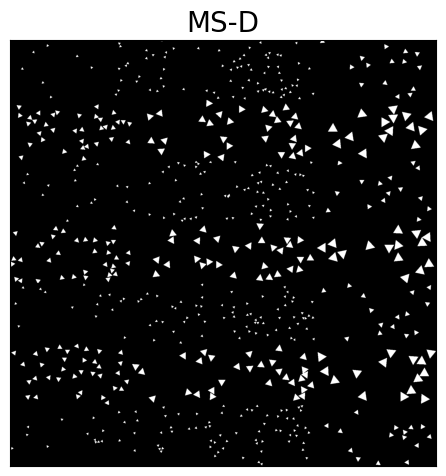

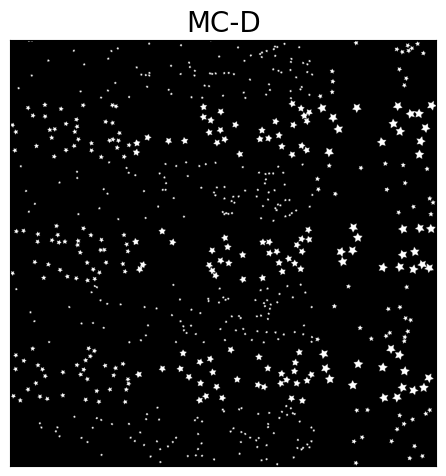

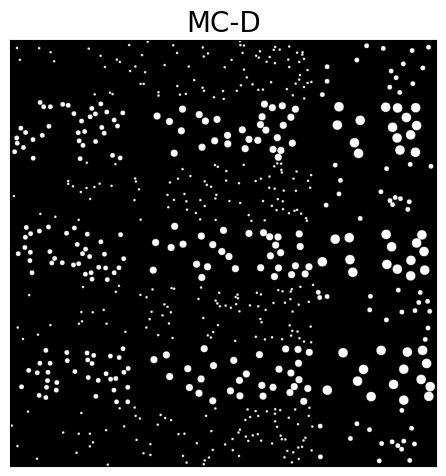

<Figure size 1000x500 with 0 Axes>

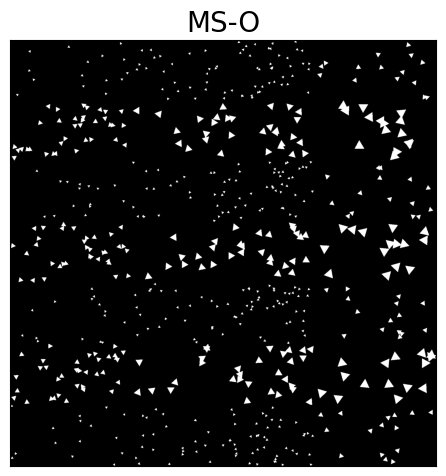

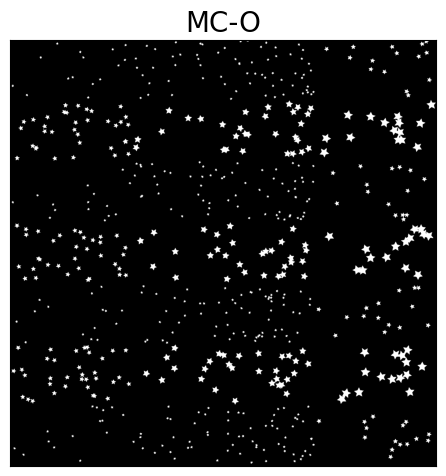

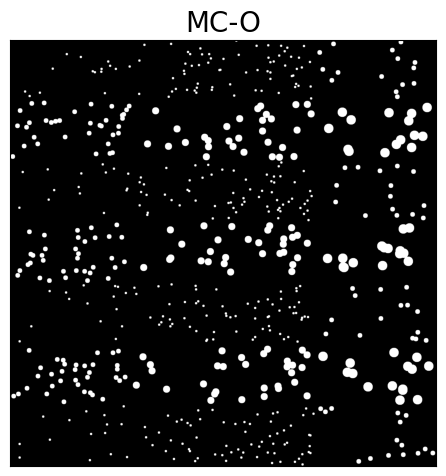

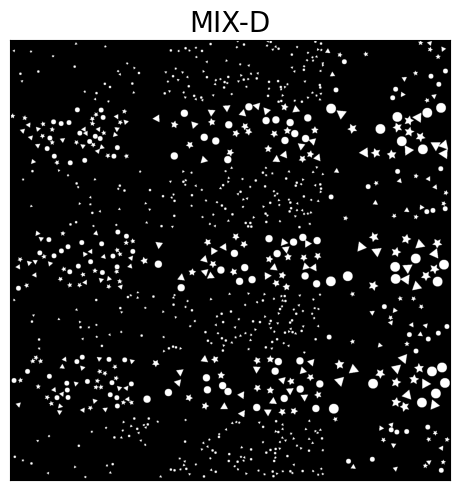

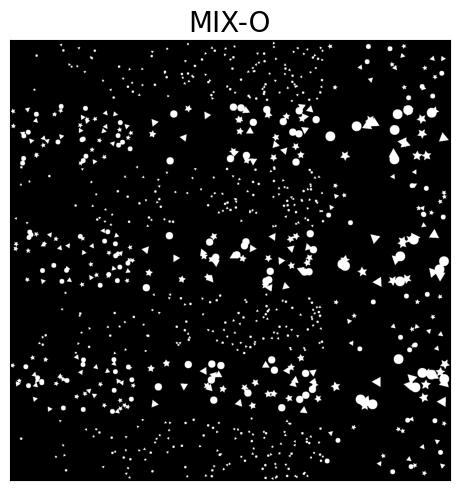

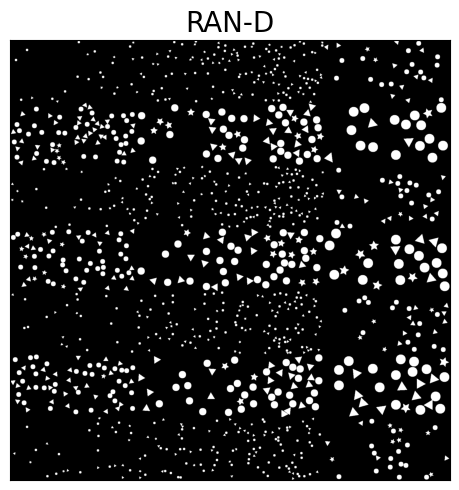

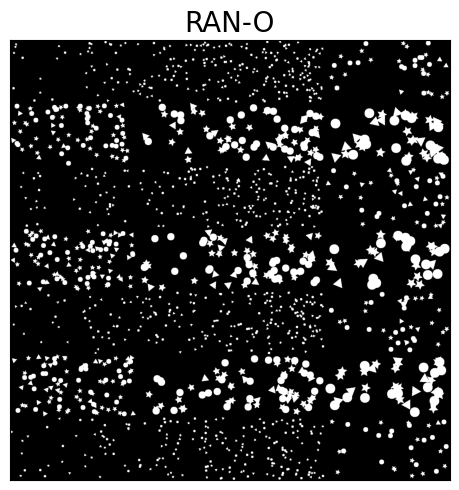

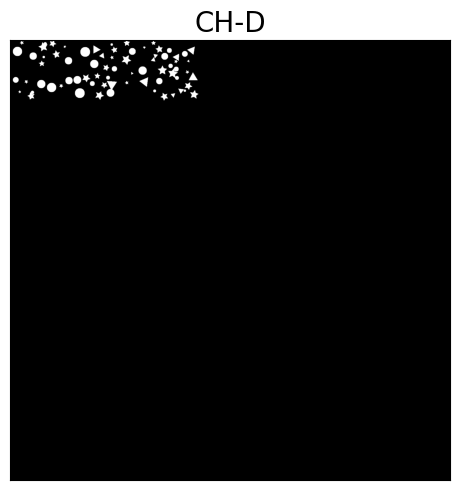

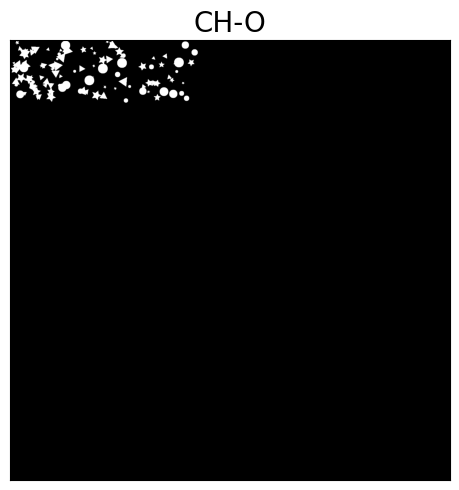

In [35]:

id = 1
for key in info["mono_distinct"]:
    plt.figure(figsize=(5, 5))

    entries = info["mono_distinct"][key]
    im = plot_images(entries)
    plt.imshow(im, cmap = "gray")
    plt.tight_layout()
    id += 1
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    if id == 2:
        plt.title("MS-D", fontsize = 20)
    else:
        plt.title("MC-D", fontsize = 20)
        


plt.figure(figsize=(10, 5))
id = 1
for key in info["mono_overlap"]:
    plt.figure(figsize=(5, 5))
    entries = info["mono_overlap"][key]
    im = plot_images(entries)
    plt.imshow(im, cmap = "gray")
    plt.tight_layout()
    # if id == 2:
    #     plt.suptitle("Mono Overlap")
    id += 1   
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    if id == 2:
        plt.title("MS-O", fontsize = 20)
    else:
        plt.title("MC-O", fontsize = 20)


plt.figure(figsize=(5,5))
plt.imshow(plot_images(info["mixed_distinct"]['shape']), cmap = "gray")
plt.title("MIX-D", fontsize = 20)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()

plt.figure(figsize=(5,5))
plt.imshow(plot_images(info["mixed_overlap"]['shape']), cmap = "gray")
plt.title("MIX-O", fontsize = 20)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()

plt.figure(figsize=(5,5))
plt.imshow(plot_images(info["random_distinct"]['shape']), cmap = "gray")
plt.title("RAN-D", fontsize = 20)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()

plt.figure(figsize=(5,5))
plt.imshow(plot_images(info["random_overlap"]['shape']), cmap = "gray")
plt.title("RAN-O", fontsize = 20)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()

plt.figure(figsize=(5,5))
plt.imshow(plot_images(info["chaos_distinct"]['shape']), cmap = "gray")
plt.title("CH-D", fontsize = 20)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()

plt.figure(figsize=(5,5))
plt.imshow(plot_images(info["chaos_overlap"]['shape']), cmap = "gray")
plt.title("CH-O", fontsize = 20)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()